In [6]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd

In [7]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [8]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [9]:
# %%
def moderate_risk_factor(df, **kwargs):
    """
    适度冒险因子 - 加密货币版本
    接受关键字参数以兼容评估器接口
    """
    # 从参数中提取配置值，设置默认值
    lookback_days = kwargs.get('lookback_days', 1)
    surge_periods = kwargs.get('surge_periods', 5)
    window_size = kwargs.get('window_size', 20)
    
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 计算交易量变化和激增时刻
    df['volume_delta'] = df['volume'].diff()
    
    # 计算动态阈值 (过去lookback_days天的均值和标准差)
    min_periods = int(lookback_days * 96)  # 每天96根15分钟K线
    df['volume_delta_mean'] = df['volume_delta'].rolling(min_periods).mean()
    df['volume_delta_std'] = df['volume_delta'].rolling(min_periods).std()
    
    # 识别激增时刻 (交易量突增超过均值+标准差)
    df['surge'] = 0
    surge_mask = (df['volume_delta'] > (df['volume_delta_mean'] + df['volume_delta_std']))
    df.loc[surge_mask, 'surge'] = 1
    
    # 2. 计算激增后的市场反应
    # 收益率计算
    df['rtn'] = df['close'].pct_change()
    
    # 激增后5期的平均收益率
    df['post_surge_ret'] = (
        df['rtn']
        .rolling(surge_periods)
        .mean()
        .shift(-surge_periods)
    )
    
    # 激增后5期的收益波动率
    df['post_surge_vol'] = (
        df['rtn']
        .rolling(surge_periods)
        .std()
        .shift(-surge_periods)
    )
    
    # 3. 聚合到日级别进行分析
    df['date'] = df.index.date
    daily_excellent = df[df['surge'] == 1].groupby('date').agg({
        'post_surge_ret': 'mean',
        'post_surge_vol': 'mean'
    }).rename(columns={
        'post_surge_ret': 'ex_ret',
        'post_surge_vol': 'ex_vol'
    })
    
    # 4. 计算与历史平均的偏离度
    # 历史20天均值和标准差
    daily_excellent['ex_ret_ma'] = daily_excellent['ex_ret'].rolling(window_size).mean()
    daily_excellent['ex_ret_std'] = daily_excellent['ex_ret'].rolling(window_size).std()
    daily_excellent['ex_vol_ma'] = daily_excellent['ex_vol'].rolling(window_size).mean()
    daily_excellent['ex_vol_std'] = daily_excellent['ex_vol'].rolling(window_size).std()
    
    # 偏离度计算 (Z-score)
    daily_excellent['moderate_ret'] = (
        (daily_excellent['ex_ret'] - daily_excellent['ex_ret_ma']) / 
        daily_excellent['ex_ret_std']
    ).abs()
    
    daily_excellent['moderate_vol'] = (
        (daily_excellent['ex_vol'] - daily_excellent['ex_vol_ma']) / 
        daily_excellent['ex_vol_std']
    ).abs()
    
    # 5. 综合因子构建
    daily_excellent['factor'] = daily_excellent['moderate_ret'] + daily_excellent['moderate_vol']
    
    # 6. 将日级因子映射回原始数据
    factor_series = df['date'].map(daily_excellent['factor'])
    
    return factor_series

In [10]:
evaluator.set_factor(
    factor_data_or_func=moderate_risk_factor,
    factor_name='moderate_risk_factor',
    factor_params={'lookback_days': 1, 'surge_periods': 5, 'window_size': 20}
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): -0.012023
   Rank_IC (Spearman): 0.001439
📊 信息比率:
   IR: -0.162007
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 128160
   因子列: moderate_risk_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


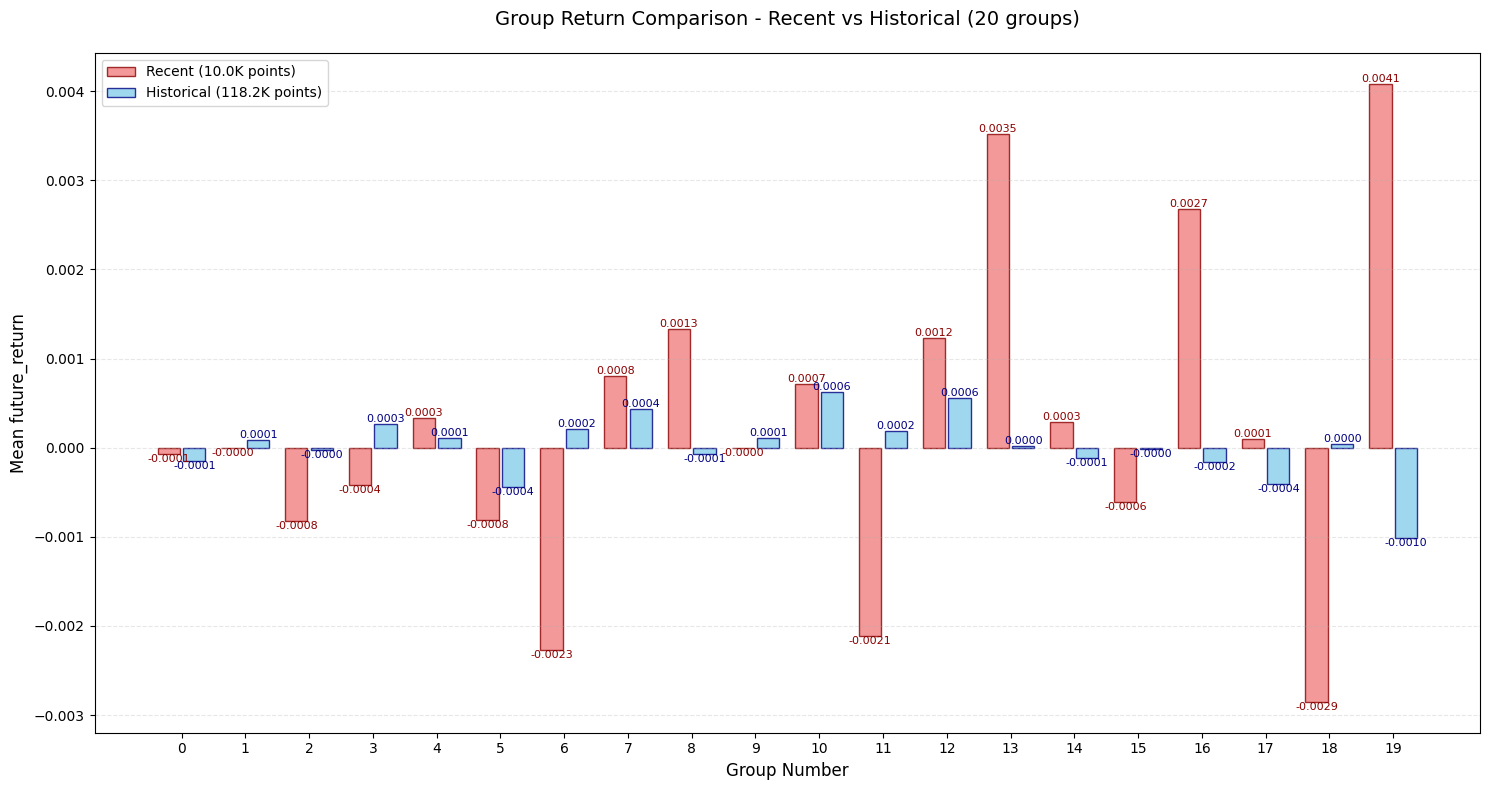

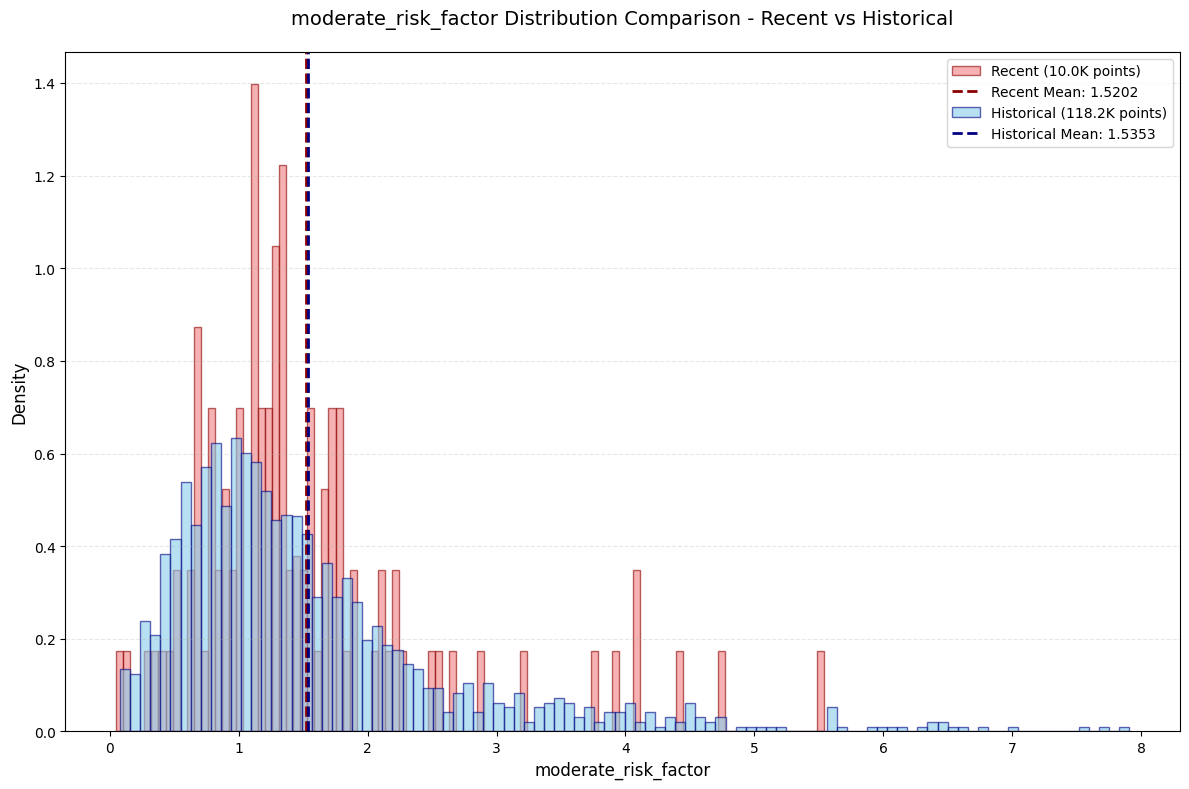

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [11]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)